### Introduction of the ideas

The core idea of my improved action detection model is to leverage the ensemble learning by extracting and fusing the last layer feature maps learned from different pretrained models. A simple way to fuse the features is to concatenate them and append a linear classification head in the end.

In [1]:
import os
import sys
import json
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler

from opts import parse_opts
from mean import get_mean, get_std
from spatial_transforms import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, ToTensor)
from temporal_transforms import LoopPadding, TemporalRandomCrop
from target_transforms import ClassLabel, VideoID
from target_transforms import Compose as TargetCompose
from dataset import get_training_set, get_validation_set, get_test_set
from utils import Logger
from train import train_epoch
from validation import val_epoch
import test
import collections
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from joblib import dump, load
from sklearn import preprocessing
from scipy import stats
from sklearn.metrics import accuracy_score

from models import *

In [2]:
# use two gpu devices on the server, you can customize it depending on how many available gpu devices you have
os.environ['CUDA_VISIBLE_DEVICES']='0'

### Set hyperparameters 

In [3]:

import easydict
opt = easydict.EasyDict({
    "result_path": 'hw6_results',      # 'Result directory path'
    "n_classes": 2,                 # 'Number of classes for fine-tuning'
    "sample_size": 112,             # 'Height and width of inputs'
    "sample_duration": 16,          # 'Temporal duration of inputs'
    "initial_scale": 1.0,           # 'Initial scale for multiscale cropping')
    "n_scales": 5,                  # 'Number of scales for multiscale cropping'
    "scale_step": 0.84089641525,    # 'Scale step for multiscale cropping'
    "train_crop": 'corner',         # 'Spatial cropping method in training. Corner is selection from 4 corners and 1 center.
    "learning_rate": 0.1,           # 'Initial learning rate (divided by 10 while training by lr scheduler)'
    "momentum": 0.9,                # 'Momentum'
    "dampening": 0.9,               # 'Dampening of SGD'
    "weight_decay": 0.001,          # 'Weight decay in SGD'
    "mean_dataset": 'kinetics',     # 'Dataset for mean values of mean subtraction'
    "no_mean_norm": False,          # 'If true, inputs are not normalized by mean'
    "std_norm": False,              # 'If true, inputs are normalized by standard deviation'
    "nesterov": False,              # 'Nesterov momentum'
    "optimizer": 'sgd',             # 'Optimizer type'
    "lr_patience": 10,              # 'Patience of LR scheduler. See documentation of Reduce on Loss Plateau Decay (ReduceLROnPlateau). https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/#reduce-on-loss-plateau-decay'
    "batch_size": 256,               # 'Batch size'
    "n_epochs": 2,                  # 'Fine-tuning epochs'
    "begin_epoch": 1,               # 'Training begins at this epoch. Previous trained model indicated by resume_path is loaded.'
    "n_val_samples": 3,             # 'Number of validation samples for each activity'
    "ft_begin_index": 5,            # 'Begin block index of fine-tuning'
    "scale_in_test": 1.0,           # 'Spatial scale in test'
    "crop_position_in_test": 'c',   #  Cropping method: center cropping
    "no_softmax_in_test": False,    # 'If true, output for each clip is not normalized using softmax.'
    "no_cuda": False,               # 'If true, cuda is not used.'
    "n_threads": 3,                 # 'Number of threads for multi-thread loading'
    "checkpoint": 2,                #  Trained model is saved at every this epochs'
    "no_hflip": False,              # 'If true holizontal flipping is not performed'
    "norm_value": 1,                # 'If 1, range of inputs is [0-255]. If 255, range of inputs is [0-1].'
    "model_depth": 101,             # 'Depth of resnet 
    "resnet_shortcut": 'B',         # 'Shortcut type of resnet' to align the dimensionality for skip connection
    "wide_resnet_k": 2,             # 'Wide resnet k'
    "resnext_cardinality": 32,      # 'ResNeXt cardinality'
    "manual_seed": 1,               # 'Manually set random seed'
    'test_subset': 'test',          # 'Used test subset name'
})
# opt.arch = '{}-{}'.format(opt.model, opt.model_depth)
opt.root_path = '/data/qq/CSCE689/'
opt.video_path = opt.root_path + 'video/UCF-101-jpg/'
opt.annotation_path = opt.root_path + 'video/UCF-music-annotation/ucf_binary_music_annotation.json'

### Load and preprocess UCF-music dataset

In [4]:
# load preprocessed video frames and annotation
from datasets.ucf101_binary import UCF101

mean = get_mean(opt.norm_value, dataset='kinetics')
std = get_std(opt.norm_value)
norm_method = Normalize(mean, [1,1,1])


spatial_transform = Compose([
    Scale(opt.sample_size),
    CornerCrop(opt.sample_size, 'c'),
    ToTensor(opt.norm_value), norm_method
])

temporal_transform = LoopPadding(opt.sample_duration)
target_transform = ClassLabel() # VideoID() # 

# get training data
training_data = UCF101(
    opt.video_path,
    opt.annotation_path,
    'training',
    0,
    spatial_transform=spatial_transform,
    temporal_transform=temporal_transform,
    target_transform=target_transform,
    sample_duration=16)

# wrap training data
train_loader = torch.utils.data.DataLoader(
    training_data,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.n_threads,
    pin_memory=False) # True


# get training data
training_data2 = UCF101(
    opt.video_path,
    opt.annotation_path,
    'training',
    0,
    spatial_transform=spatial_transform,
    temporal_transform=temporal_transform,
    target_transform=VideoID(),
    sample_duration=16)

# wrap training data
train_loader2 = torch.utils.data.DataLoader(
    training_data2,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=5,
    pin_memory=False) # True



# get validation data
val_data = UCF101(
    opt.video_path,
    opt.annotation_path,
    'validation',
    0,
    spatial_transform=spatial_transform,
    temporal_transform=temporal_transform,
    target_transform=target_transform,
    sample_duration=16)

# wrap validation data
val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.n_threads,
    pin_memory=False) 

# get validation data
val_data2 = UCF101(
    opt.video_path,
    opt.annotation_path,
    'validation',
    0,
    spatial_transform=spatial_transform,
    temporal_transform=temporal_transform,
    target_transform=VideoID(),
    sample_duration=16)

# wrap validation data
val_loader2 = torch.utils.data.DataLoader(
    val_data2,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=5,
    pin_memory=False) 




# Directly predict videoID for test data
target_transform = VideoID()

# get test data
test_data = UCF101(
    opt.video_path,
    opt.annotation_path,
    'testing',
    0,
    spatial_transform=spatial_transform,
    temporal_transform=temporal_transform,
    target_transform=target_transform,
    sample_duration=16)


# wrap test data
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.n_threads,
    pin_memory=False)

dataset loading [0/9537]
dataset loading [1000/9537]
dataset loading [2000/9537]
dataset loading [3000/9537]
dataset loading [4000/9537]
dataset loading [5000/9537]
dataset loading [6000/9537]
dataset loading [7000/9537]
dataset loading [8000/9537]
dataset loading [9000/9537]
dataset loading [0/9537]
dataset loading [1000/9537]
dataset loading [2000/9537]
dataset loading [3000/9537]
dataset loading [4000/9537]
dataset loading [5000/9537]
dataset loading [6000/9537]
dataset loading [7000/9537]
dataset loading [8000/9537]
dataset loading [9000/9537]
dataset loading [0/2183]
dataset loading [1000/2183]
dataset loading [2000/2183]
dataset loading [0/2183]
dataset loading [1000/2183]
dataset loading [2000/2183]
dataset loading [0/1600]
dataset loading [1000/1600]


In [5]:
# 152592.0/9537, 30562.0/2183, 6400.0/1600


### Extract features of ResNeXt - 101 and save in disk

In [6]:
# from models import resnext

# # construct model architecture
# model_rxt101 = resnext.resnet101(
#                 num_classes=opt.n_classes,
#                 shortcut_type=opt.resnet_shortcut,
#                 cardinality=opt.resnext_cardinality,
#                 sample_size=opt.sample_size,
#                 sample_duration=opt.sample_duration)

# model_rxt101 = model_rxt101.cuda()
# # wrap the current model again in nn.DataParallel / or we can just remove the .module keys.
# model_rxt101 = nn.DataParallel(model_rxt101, device_ids=None)


# ### Load pretrained weight
# # customize the pretrained model path
# pretrain = torch.load(opt.root_path + 'pretrain/resnext-101-kinetics.pth')
# pretrain_dict = pretrain['state_dict']

# # do not load the last layer since we want to fine-tune it
# pretrain_dict.pop('module.fc.weight')
# pretrain_dict.pop('module.fc.bias')
# model_dict = model_rxt101.state_dict()
# model_dict.update(pretrain_dict) 
# model_rxt101.load_state_dict(model_dict)

In [7]:
# # register layer index to extract the features by forwarding all the video clips
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

# model_rxt101.module.avgpool.register_forward_hook(get_activation('avgpool'))
# model_rxt101.eval()


# # forward all the videos to extract features
# avgpool, avgpool_val, avgpool_test = [], [], []
# targets, targets_val, targets_test = [], [], []
# with torch.no_grad():
#     print("Extract train set features:")
#     for i, (inputs, target) in enumerate(train_loader):
#         if i % 30 == 0:
#             print(i)
#         output = model_rxt101(inputs)
#         avgpool.append(activation['avgpool'].view(len(target), -1).cpu())
#         targets.append(target)
    
#     print("Extract val set features:")
#     for i, (inputs, target) in enumerate(val_loader):
#         if i % 30 == 0:
#             print(i)
#         output = model_rxt101(inputs)
#         avgpool_val.append(activation['avgpool'].view(len(target), -1).cpu())
#         targets_val.append(target)
 
#     print("Extract test set features:")
#     for i, (inputs, target) in enumerate(test_loader):
#         if i % 30 == 0:
#             print(i)
#         output = model_rxt101(inputs)
#         avgpool_test.append(activation['avgpool'].view(len(target), -1).cpu())
#         targets_test.append(target)



In [8]:
# # save the features
# avgpool_np = np.concatenate([i.numpy() for i in avgpool], axis=0)
# np.save(opt.root_path + 'feature_ucf_all/resnext101_avgpool_train.npy', avgpool_np)

# targets_np = np.concatenate([i.numpy() for i in targets], axis=0)
# np.save(opt.root_path + 'feature_ucf_all/class_names_ucf_train.npy', targets_np)

# avgpool_val_np = np.concatenate([i.numpy() for i in avgpool_val], axis=0)
# np.save(opt.root_path + 'feature_ucf_all/resnext101_avgpool_val.npy', avgpool_val_np)

# targets_val_np = np.concatenate([i.numpy() for i in targets_val], axis=0)
# np.save(opt.root_path + 'feature_ucf_all/class_names_ucf_val.npy', targets_val_np)

# avgpool_test_np = np.concatenate([i.numpy() for i in avgpool_test], axis=0)
# np.save(opt.root_path + 'feature_ucf_all/resnext101_avgpool_test.npy', avgpool_test_np)

# targets_test_np = np.concatenate(np.array(targets_test), axis=0)
# np.save(opt.root_path + 'feature_ucf_all/class_names_ucf_test.npy', targets_test_np)

### Extract features of ResNet-50 and save in disk

In [9]:
# from models import resnet

# # construct model architecture
# model_rt50 = resnet.resnet50(
#                 num_classes=opt.n_classes,
#                 shortcut_type=opt.resnet_shortcut,
#                 sample_size=opt.sample_size,
#                 sample_duration=opt.sample_duration)

# model_rt50 = model_rt50.cuda()
# # wrap the current model again in nn.DataParallel / or we can just remove the .module keys.
# model_rt50 = nn.DataParallel(model_rt50, device_ids=None)


# ### Load pretrained weight
# # customize the pretrained model path
# pretrain = torch.load(opt.root_path + 'pretrain/resnet-50-kinetics.pth')
# pretrain_dict = pretrain['state_dict']

# # do not load the last layer since we want to fine-tune it
# pretrain_dict.pop('module.fc.weight')
# pretrain_dict.pop('module.fc.bias')
# model_dict = model_rt50.state_dict()
# model_dict.update(pretrain_dict) 
# model_rt50.load_state_dict(model_dict)


/home/qq/CSCE689/3D-ResNets-PyTorch/models/resnet.py:145: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


<All keys matched successfully>

In [12]:
# # register layer index to extract the features by forwarding all the video clips
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

# model_rt50.module.avgpool.register_forward_hook(get_activation('avgpool'))
# model_rt50.eval()


# # forward all the videos to extract features
# avgpool, avgpool_val, avgpool_test = [], [], []
# with torch.no_grad():
#     print("Extract val set features:")
#     for i, (inputs, target) in enumerate(val_loader):
#         if i % 30 == 0:
#             print(i)
#         output = model_rt50(inputs)
#         avgpool_val.append(activation['avgpool'].view(len(target), -1).cpu())
 
#     # save the features
#     avgpool_val_np = np.concatenate([i.numpy() for i in avgpool_val], axis=0)
#     np.save(opt.root_path + 'feature_ucf_all/resnet50_avgpool_val.npy', avgpool_val_np)
    
    
#     print("Extract test set features:")
#     for i, (inputs, target) in enumerate(test_loader):
#         if i % 30 == 0:
#             print(i)
#         output = model_rt50(inputs)
#         avgpool_test.append(activation['avgpool'].view(len(target), -1).cpu())
        
#     # save the features
#     avgpool_test_np = np.concatenate([i.numpy() for i in avgpool_test], axis=0)
#     np.save(opt.root_path + 'feature_ucf_all/resnet50_avgpool_test.npy', avgpool_test_np)    
 
#     print("Extract train set features:")
#     for i, (inputs, target) in enumerate(train_loader):
#         if i % 30 == 0:
#             print(i)
#         output = model_rt50(inputs)
#         avgpool.append(activation['avgpool'].view(len(target), -1).cpu())
    
#     # save the features
#     avgpool_np = np.concatenate([i.numpy() for i in avgpool], axis=0)
#     np.save(opt.root_path + 'feature_ucf_all/resnet50_avgpool_train.npy', avgpool_np)
    

### Load and fuse (concatenate) features and fine-tune an appended classification layer

In [6]:
x_train_1 = np.load(opt.root_path + 'feature_ucf_all/resnext101_avgpool_train.npy')
x_train_2 = np.load(opt.root_path + 'feature_ucf_all/resnet50_avgpool_train.npy')

x_val_1 = np.load(opt.root_path + 'feature_ucf_all/resnext101_avgpool_val.npy')
x_val_2 = np.load(opt.root_path + 'feature_ucf_all/resnet50_avgpool_val.npy')

x_test_1 = np.load(opt.root_path + 'feature_ucf_all/resnext101_avgpool_test.npy')
x_test_2 = np.load(opt.root_path + 'feature_ucf_all/resnet50_avgpool_test.npy')

y_train = 1 - np.load(opt.root_path + 'feature_ucf_all/class_names_ucf_train.npy')
y_val = 1 - np.load(opt.root_path + 'feature_ucf_all/class_names_ucf_val.npy')
y_test = np.load(opt.root_path + 'feature_ucf_all/class_names_ucf_test.npy')
y = np.concatenate([y_train, y_val], axis=0)

x_train = np.concatenate([x_train_1, x_train_2], axis=1)
x_val = np.concatenate([x_val_1, x_val_2], axis=1)
x_test = np.concatenate([x_test_1, x_test_2], axis=1)
X = np.concatenate([x_train, x_val], axis=0)

In [7]:
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test

((114779, 4096),
 (26018, 4096),
 (18873, 4096),
 (114779,),
 (26018,),
 array(['v_BasketballDunk_g01_c02', 'v_BasketballDunk_g01_c02',
        'v_BasketballDunk_g01_c02', ..., 'v_Nunchucks_g06_c03',
        'v_Nunchucks_g06_c03', 'v_Nunchucks_g06_c03'], dtype='<U28'))

##### Get ground truth

In [8]:
with open(opt.annotation_path) as rfp:
    annotations = json.load(rfp)

ground_truth_all = []
for k in y_test:
    ground_truth_all.append(annotations['database'][k]['annotations']['label'])
    
    
name_to_int = {v:1-k for k,v in test_data.class_names.items()}

split_idx = []
for idx, y_name in enumerate(y_test):
    if idx == 0 or y_name != y_test[idx-1]:
        split_idx.append(idx)

ground_truth = []
for i, split in enumerate(split_idx):
    if i < len(split_idx) - 1:
        ground_truth.append(name_to_int[ground_truth_all[split]])
        
ground_truth_all_num = []
for i in ground_truth_all:
    ground_truth_all_num.append(name_to_int[i])
    
len(ground_truth_all), len(ground_truth), len(ground_truth_all_num)

(18873, 1587, 18873)

## Fine-tune the pretrained model on the targe UCF-101 dataset

### Fit three logistic regression classifier on (1) ResNeXt features (2) ResNet features (3) Combined features

In [17]:
# from sklearn.linear_model import LogisticRegression
# # Create logistic Regression Classifiers
# clf1 = LogisticRegression(random_state=0)
# clf2 = LogisticRegression(random_state=0)
# clf = LogisticRegression(random_state=0)

# # Train the model using the training sets
# clf1.fit(x_train_1, y_train)
# clf2.fit(x_train_2, y_train)    
# clf.fit(x_train, y_train) # combine                     
                         
# # save model
# dump(clf1, './hw6_results/logistic1_ucf.joblib') 
# dump(clf2, './hw6_results/logistic2_ucf.joblib') 
# dump(clf, './hw6_results/logistic_ucf.joblib') 

/home/qq/.virtualenvs/csce689/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/qq/.virtualenvs/csce689/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

['./hw6_results/logistic_ucf.joblib']

In [10]:
# load model
clf1 = load('./hw6_results/logistic1_ucf.joblib') 
clf2 = load('./hw6_results/logistic2_ucf.joblib') 
clf = load('./hw6_results/logistic_ucf.joblib') 

In [11]:
# Get Test Probability
y_test_prob1 = clf1.predict_proba(x_test_1)
y_test_prob2 = clf2.predict_proba(x_test_2)
y_test_prob = clf.predict_proba(x_test)


# y_test_prob1 = clf1.predict(x_test_1)
# y_test_prob2 = clf2.predict(x_test_2)
# y_test_prob = clf.predict(x_test)

### Test, compare the models

##### ResNeXt-101 feature +  Resnet-50 feature + logisticRegressionClassifier

General Accuracy: 0.996219281663516

              precision    recall  f1-score   support

         Yes       1.00      1.00      1.00      1440
          No       0.96      1.00      0.98       147

    accuracy                           1.00      1587
   macro avg       0.98      1.00      0.99      1587
weighted avg       1.00      1.00      1.00      1587



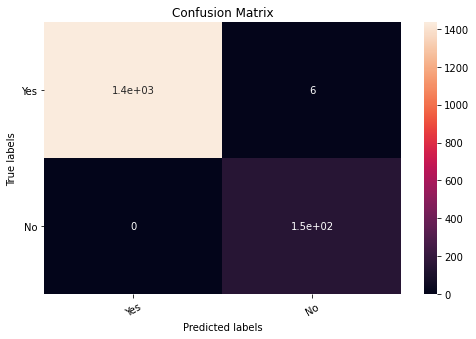

In [12]:
# get ground-truth split
name_to_int = {v:k for k,v in test_data.class_names.items()}

split_idx = []
for idx, y_name in enumerate(y_test):
    if idx == 0 or y_name != y_test[idx-1]:
        split_idx.append(idx)

y_pred_test = []
for i, split in enumerate(split_idx):
    if i < len(split_idx) - 1:
        y_pred_test.append(np.argmax(np.mean(y_test_prob[split:split_idx[i+1]], axis=0)))
        
# Display the testing results
acc = accuracy_score(ground_truth, y_pred_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("General Accuracy: {}\n".format(accuracy_score(ground_truth, y_pred_test)))
print(classification_report(ground_truth, y_pred_test, target_names=list(test_data.class_names.values())))

cm = confusion_matrix(ground_truth, y_pred_test, labels=list(test_data.class_names.keys()))
import seaborn as sns
import matplotlib.pyplot as plt     

fig=plt.figure(figsize=(8, 5))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(test_data.class_names.values()), rotation=30); 
ax.yaxis.set_ticklabels(list(test_data.class_names.values()), rotation=0);

##### ResNeXt-101 feature + logisticRegressionClassifier

General Accuracy: 0.9955891619407687

              precision    recall  f1-score   support

         Yes       1.00      1.00      1.00      1440
          No       0.95      1.00      0.98       147

    accuracy                           1.00      1587
   macro avg       0.98      1.00      0.99      1587
weighted avg       1.00      1.00      1.00      1587



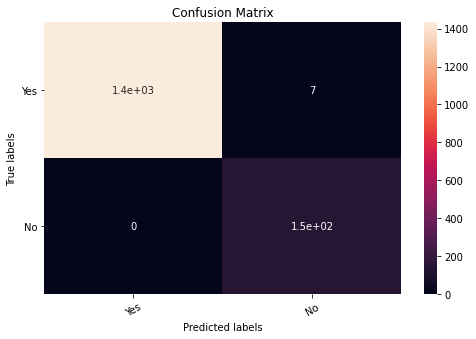

In [13]:
# get ground-truth split
name_to_int = {v:k for k,v in test_data.class_names.items()}

split_idx = []
for idx, y_name in enumerate(y_test):
    if idx == 0 or y_name != y_test[idx-1]:
        split_idx.append(idx)

y_pred_test = []
for i, split in enumerate(split_idx):
    if i < len(split_idx) - 1:
        y_pred_test.append(np.argmax(np.mean(y_test_prob1[split:split_idx[i+1]], axis=0)))
        
# Display the testing results
acc = accuracy_score(ground_truth, y_pred_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("General Accuracy: {}\n".format(accuracy_score(ground_truth, y_pred_test)))
print(classification_report(ground_truth, y_pred_test, target_names=list(test_data.class_names.values())))

cm = confusion_matrix(ground_truth, y_pred_test, labels=list(test_data.class_names.keys()))
import seaborn as sns
import matplotlib.pyplot as plt     

fig=plt.figure(figsize=(8, 5))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(test_data.class_names.values()), rotation=30); 
ax.yaxis.set_ticklabels(list(test_data.class_names.values()), rotation=0);

##### Resnet-50 feature + logisticRegressionClassifier

General Accuracy: 0.9918084436042848

              precision    recall  f1-score   support

         Yes       1.00      0.99      1.00      1440
          No       0.94      0.98      0.96       147

    accuracy                           0.99      1587
   macro avg       0.97      0.99      0.98      1587
weighted avg       0.99      0.99      0.99      1587



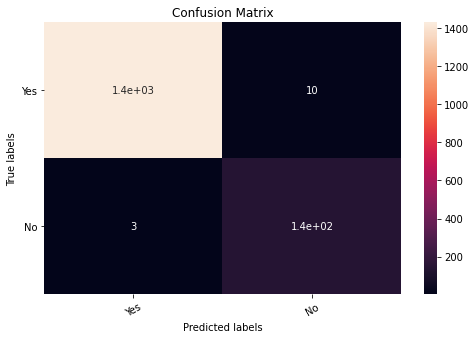

In [14]:
# get ground-truth split
name_to_int = {v:k for k,v in test_data.class_names.items()}

split_idx = []
for idx, y_name in enumerate(y_test):
    if idx == 0 or y_name != y_test[idx-1]:
        split_idx.append(idx)

y_pred_test = []
for i, split in enumerate(split_idx):
    if i < len(split_idx) - 1:
        y_pred_test.append(np.argmax(np.mean(y_test_prob2[split:split_idx[i+1]], axis=0)))
        
# Display the testing results
acc = accuracy_score(ground_truth, y_pred_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("General Accuracy: {}\n".format(accuracy_score(ground_truth, y_pred_test)))
print(classification_report(ground_truth, y_pred_test, target_names=list(test_data.class_names.values())))

cm = confusion_matrix(ground_truth, y_pred_test, labels=list(test_data.class_names.keys()))
import seaborn as sns
import matplotlib.pyplot as plt     

fig=plt.figure(figsize=(8, 5))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(test_data.class_names.values()), rotation=30); 
ax.yaxis.set_ticklabels(list(test_data.class_names.values()), rotation=0);